In [1]:
import warnings
warnings.filterwarnings('ignore')

In [282]:
import numpy as np
from numpy.random import choice
from scipy.optimize import curve_fit

In [3]:
import matplotlib.pyplot as plt
from plotting import initialize_plot_settings
initialize_plot_settings()

In [4]:
from disloc import deform_dislocation
from utils import load_and_mask_results, rotate

In [5]:
ORIGIN_X = 321660
ORIGIN_Y = 4164942

## 1D model, Lidar

In [6]:
def center_profiles(uobs, utrue, dx=25):
    n = len(uobs)
    idx = np.where(uobs == np.sign(uobs) * np.min(np.abs(uobs)))[0][0]
    xp = np.arange(2*(n - idx), dtype=float)
    xp -= np.mean(xp)
    x = dx * xp - dx / 2
    if 2*idx - n < 0:
        return x[np.abs(2*idx - n)+1:], uobs[np.abs(2*idx - n):], utrue[np.abs(2*idx - n):]        
    return x, uobs[(2*idx - n):], utrue[(2*idx - n):]

In [223]:
def rmse(ypred, yobs):
    return np.sqrt(np.nanmean((ypred - yobs) ** 2))

In [224]:
def model_1d(x, depth, s):
    delta = 89.999
    deltarad = np.deg2rad(delta)
    zeta = (x / depth) - (1 / np.tan(deltarad))
    u1 = (s/np.pi)*(np.cos(deltarad)*np.arctan(zeta) + (np.sin(deltarad) - zeta*np.cos(deltarad))/(1+np.power(zeta,2)))
    u2 = (-s/np.pi)*(np.sin(deltarad)*np.arctan(zeta) + (np.cos(deltarad) + zeta*np.sin(deltarad))/(1+np.power(zeta,2)))
    return u2

In [10]:
depth = 100
dip_slip = 1
dxs = [5, 12.5, 25, 50, 100]

In [11]:
us = np.load('profiles/lidar_ds_applied.npy', allow_pickle=True)

In [12]:
uicps = np.load('profiles/lidar_ds_observed.npy', allow_pickle=True)

In [13]:
dx = dxs[0]
uobs = uicps[0]
utrue = us[0]

In [14]:
xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)

In [15]:
phat, pcov = curve_fit(model_1d, xp, uobsc)
uhat = model_1d(xp, *phat)
print(phat)

[-71.09187906   1.00584919]


In [16]:
print(chi_sq(uhat, uobsc))

42.98803443852893


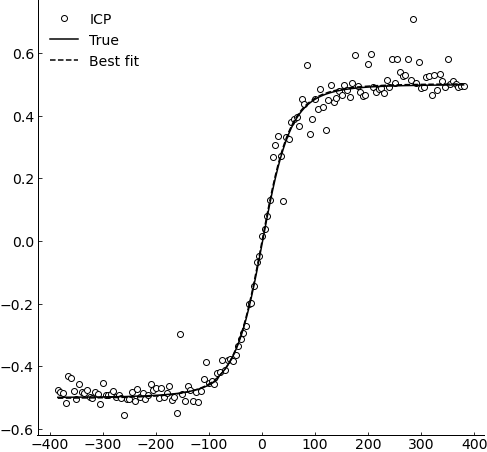

In [17]:
plt.plot(xp, uobsc, 'wo', mec='k', label='ICP')
plt.plot(xp, utruec, 'k-', label='True')
plt.plot(xp, uhat, 'k--', label='Best fit')
plt.legend()

fig, axes = plt.subplots(len(dxs), 1, figsize=(6, 3 * len(dxs)), sharex=True)
letters = ['A', 'B', 'C', 'D', 'E']
for ax, letter, dx, utrue, uobs in zip(axes, letters, dxs, us, uicps):
    x, uobsc, _ = center_profiles(uobs, utrue, dx=dx)
    phat, pcov = curve_fit(model_1d, x, uobsc)
    uhat = model_1d(xp, *phat)
    ax.plot(x, uobsc, 'wo', mec='k', label='Measured (ICP)')
    ax.plot(xp, utruec, 'k-', label='True')
    ax.plot(xp, uhat, 'k--', label='Best fit')
        
    ax.text(0.025, 0.9, letter, transform=ax.transAxes, fontsize=14)
    ax.text(0.75, 0.1, "$dx$ = " + f"{dx:.1f} m\n" + "$\hat{d}$ = " + f"{phat[0]:.2f} m \n" + "$\hat{s_z}$ = " + f"{phat[1]:.2f} m", transform=ax.transAxes, fontsize=14)
        
axes[0].legend()        
axes[-1].set_xticks([-400, 0, 400])
axes[-1].set_xticklabels(['0', '400', '800'])
axes[-1].set_xlabel('Distance [m]')
axes[2].set_ylabel('Displacement $u_z$ [m]')

plt.savefig('/media/rmsare/data/fig/hsl_icp/FigureSX_LidarResolutionDSModels.png', dpi=300, bbox_inches='tight')

## Misfit plots

## Dip slip

In [227]:
def plot_rmse(uobs, utrue, dx=25):
    xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)

    depths = np.linspace(0, -500, num=100) + 0.01
    slips = np.linspace(0, 5, num=100) + 0.01
    rmses = np.full((len(depths), len(slips)), fill_value=np.nan)
    extent = (min(slips), max(slips), min(depths), max(depths))

    for i, depth in enumerate(depths):
        for j, s in enumerate(slips):
            upred = model_1d(xp, depth, s)
            rmses[i, j] = rmse(upred, uobsc)        
    
    plt.figure()
    im = plt.imshow(np.log10(rmses), extent=extent, cmap='viridis_r')
    _ = plt.contour(np.log10(rmses), [-1, -0.75, -0.5, -0.25, 0], extent=extent, colors='w', origin='upper')
    plt.colorbar(im, label='log$_{10}$ RMSE [m]', orientation='horizontal', shrink=0.5)
    plt.gca().set_aspect(0.005)
    plt.xlabel('Slip [m]')
    plt.ylabel('Depth [m]')
    
    idx = np.where(rmses == rmses.min())
    i = idx[0][0]
    j = idx[1][0]
    print(f'Min. RMSE: dx = {dx:.1f} m depth = {depths[i]:.1f} m, slip = {slips[j]:.1f} m, RMSE = {rmses[i, j]:.2f} m')

Min. RMSE: dx = 5.0 m depth = -75.7 m, slip = 1.0 m, RMSE = 0.05 m
Min. RMSE: dx = 12.5 m depth = -75.7 m, slip = 1.0 m, RMSE = 0.04 m
Min. RMSE: dx = 25.0 m depth = -70.7 m, slip = 1.0 m, RMSE = 0.05 m
Min. RMSE: dx = 50.0 m depth = -101.0 m, slip = 1.1 m, RMSE = 0.06 m
Min. RMSE: dx = 100.0 m depth = -212.1 m, slip = 1.4 m, RMSE = 0.11 m


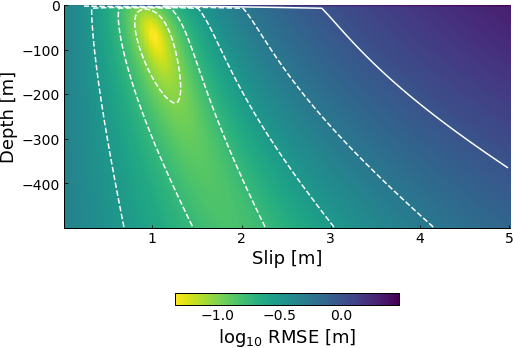

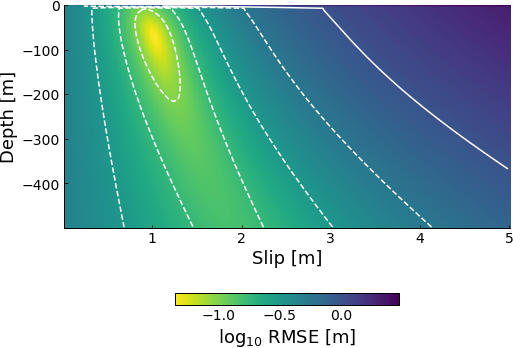

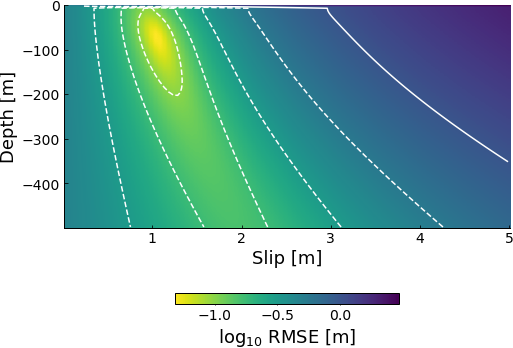

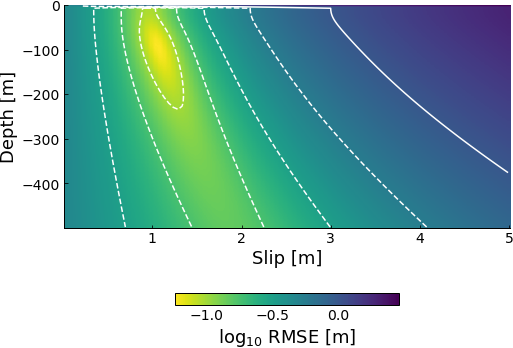

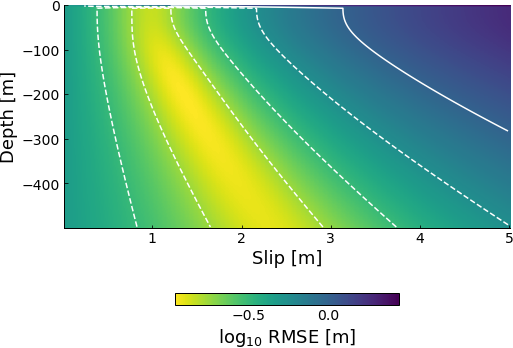

In [228]:
for uobs, utrue, dx in zip(uicps, us, dxs):
    plot_rmse(uobs, utrue, dx=dx)

## Bootstrap

In [283]:
def get_bootstrap_dists(x, uobs, nboot=100, **kwargs):
    depths_b = []
    slips_b = []

    for i in range(nboot):
        idx = choice(range(len(uobs)), size=len(uobs), replace=True)
        xboot = xp[idx]
        uboot = uobsc[idx]
        phat, pcov = curve_fit(model_1d, xboot, uboot, **kwargs)
        depths_b.append(phat[0])
        slips_b.append(phat[1])
    
    return depths_b, slips_b

In [284]:
def plot_bootstrap_dists(depths_b, slips_b):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    ax[0].hist(depths_b, bins=30, color='0.5', ec='w')
    ymin, ymax = ax[0].set_ylim()
    ax[0].vlines(np.nanmedian(depths_b), ymin, ymax, colors='r', linestyles='-')
    ax[0].vlines(np.nanpercentile(depths_b, [2.5, 97.5]), ymin, ymax, colors='k', linestyles='--')
    ax[0].set_xlabel('Depth [m]')
    ax[0].set_ylabel('Count')

    ax[1].hist(slips_b, bins=30, color='0.5', ec='w')
    ymin, ymax = ax[1].set_ylim()
    ax[1].vlines(np.nanmedian(slips_b), ymin, ymax, colors='r', linestyles='-')
    ax[1].vlines(np.nanpercentile(slips_b, [2.5, 97.5]), ymin, ymax, colors='k', linestyles='--')
    ax[1].set_xlabel('Slip [m]')

In [ ]:
for uobs, utrue, dx in zip(uicps, us, dxs):
    xp, uobsc, utruec = center_profiles(uobs, utrue, dx=dx)
    depths_b, slips_b = get_bootstrap_dists(xp, uobsc, nboot=1000)
    plot_bootstrap_dists(depths_b, slips_b)
    plt.suptitle(f'dx = {dx:.1f}')